# LTHU beam loss 

This script shows how a beam loss can be specified at a particular s location.

It is somewhat hackey, using the unstable.orbit datum which wants a relative index for the loss point. 

In [1]:
# Useful for debugging
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'

from pytao import TaoModel

In [4]:
# Load model
M = TaoModel('tao.init', ploton=True)

Initialized Tao with /tmp/tmpcmhfwhic/tao/tao.init


In [5]:
# Get info to lookup indices

# Helper function
def lat_names(match='*'):
    return np.array(M.cmd(f'python lat_list -track_only >>{match}|model ele.name'))

ELE_S = np.array(M.cmd('python lat_list -track_only >>*|model ele.s')).astype('float')



ELE_NAMES = lat_names().tolist()
END_ELE = ELE_NAMES[-1]
IX_REF = ELE_NAMES.index(END_ELE)
S_REF = ELE_S[IX_REF]

# Get floor Z
FLOOR_Z = np.array(M.evaluate(f'lat::floor.z[beginning:{END_ELE}]'))

MIN_Z = FLOOR_Z[0]
MAX_Z = FLOOR_Z[-1]

END_ELE, ELE_NAMES.index(END_ELE)

('DTDUND2', 2385)

In [6]:
# Z range
FLOOR_Z[0], FLOOR_Z[-1]

(3224.76242303644, 3561.33382646055)

In [7]:
# Simple helper function
def s_from_z(z):
    """
    Floor Z from s
    """
    
    if z < MIN_Z:
        raise ValueError(f'Error: Z = {z} is less than the minumum {MIN_Z}')
        
    if z > MAX_Z:
        raise ValueError(f'Error: Z = {z} is greater than the maximum {MAX_Z}')        
    
    return np.interp(z, FLOOR_Z, ELE_S)


s_from_z(3300)

1285.3385798036663

In [8]:
# Use all correctors. There should only be one datum: loss.rel_point
M.cmd('use var correctors.x')
M.cmd('set var correctors.x|meas =0') 
M.cmd('set var correctors.x|weight =1e8')
M.cmd('use dat loss.rel_point')
M.cmd('set dat loss.rel_point|weight = 1')
M.cmd('sho dat')

['',
 '  Name                                 Using for Optimization',
 '  aperture.p[0:979]                              Using:',
 '  aperture.n[0:979]                              Using:',
 '  orbit.x[1:29]                                  Using:',
 '  orbit.y[1:0]                                   Using:',
 '  orbit.profx[1:0]                               Using:',
 '  orbit.profy[1:0]                               Using:',
 '  orbit.e[1:0]                                   Using:',
 '  loss[1:1]                                      Using: 1']

In [9]:
def set_loss_s(s):
    """
    Sets the appropriate loss 
    """
    M.cmd(f'set dat loss.rel_point|ele_name ={END_ELE}')
        
    ix_target = np.abs(ELE_S-s).argmin()
    
    M.cmd(f'set dat loss.rel_point|meas ={IX_REF-ix_target}')
    return ELE_S[ix_target], ELE_NAMES[ix_target]

# Similar to above, but for z
def set_loss_z(z):
    
    s = s_from_z(z)
    print(f'Setting loss at s = {s} m, Z = {z} m')
    return set_loss_s(s)

set_loss_s(1280)
set_loss_z(3400)

Setting loss at s = 1385.345074975222 m, Z = 3400 m


(1385.35007502969, 'DMM1M90CM#7')

In [10]:
# Reset lattice
def reset():
    M.cmd('set lattice model=design')
    # Turn off collimators
    M.cmd('set ele rcoll::* x1_limit = 20e-3')
    M.cmd('set ele rcoll::* x2_limit = 20e-3')    
reset()

In [11]:
# Use the DE optimizer - it has enough noise to seed a loss
# Play with these numbers to make it faster/more accurate
M.cmd('scycles 5')
M.cmd('sde 1000')
M.cmd('ode')
#M.cmd('olmdif')

[]

In [12]:
def try_loss_z(zloss):
    #reset()
    set_loss_z(zloss)
    M.cmd('run')
    ix_loss = int(IX_REF - M.evaluate('data::loss.rel_point[1]|model'))
    s_lost_actual = ELE_S[ix_loss]
    z_loss_actual = FLOOR_Z[ix_loss]
    print(f'Actual loss at s = {s_lost_actual} m, Z = {z_loss_actual} m')
    return z_loss_actual


In [14]:
# Try one place at s
try_loss_z(3500)

Setting loss at s = 1485.346164736435 m, Z = 3500 m
Actual loss at s = 1489.2532073134 m, Z = 3503.90699999999 m


3503.90699999999

In [15]:
# Loop over some loss points in Z
Z_TRY = np.linspace(MAX_Z,MIN_Z,20)
Z_ACTUAL = []
for zloss in Z_TRY:
    zact = try_loss_z(zloss)
    Z_ACTUAL.append(zact)
    

Setting loss at s = 1546.68065958926 m, Z = 3561.33382646055 m
Actual loss at s = 1546.68065958926 m, Z = 3561.33382646055 m
Setting loss at s = 1528.9661821550978 m, Z = 3543.6195420698073 m
Actual loss at s = 1546.68065958926 m, Z = 3561.33382646055 m
Setting loss at s = 1511.251704720957 m, Z = 3525.9052576790646 m
Actual loss at s = 1516.10649994698 m, Z = 3530.75999999999 m
Setting loss at s = 1493.5372272868065 m, Z = 3508.190973288322 m
Actual loss at s = 1489.2532073134 m, Z = 3503.90699999999 m
Setting loss at s = 1475.8227498526687 m, Z = 3490.4766888975796 m
Actual loss at s = 1487.12018406879 m, Z = 3501.77399999999 m
Setting loss at s = 1458.1082724185235 m, Z = 3472.762404506837 m
Actual loss at s = 1462.10891150861 m, Z = 3476.76299999999 m
Setting loss at s = 1440.3937949843776 m, Z = 3455.048120116094 m
Actual loss at s = 1452.42380596524 m, Z = 3467.07799999999 m
Setting loss at s = 1422.6793175502296 m, Z = 3437.3338357253515 m
Actual loss at s = 1436.48063222461 m, 

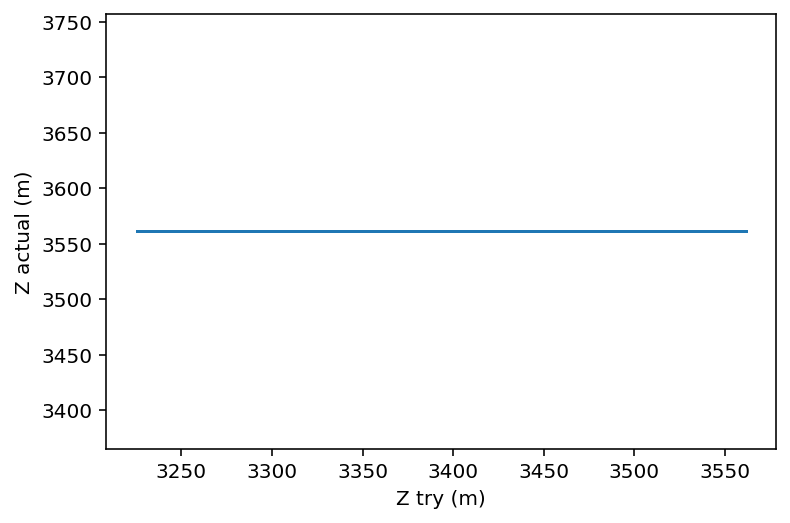

In [15]:
plt.xlabel('Z try (m)')
plt.ylabel('Z actual (m)')
plt.plot(Z_TRY, Z_ACTUAL)


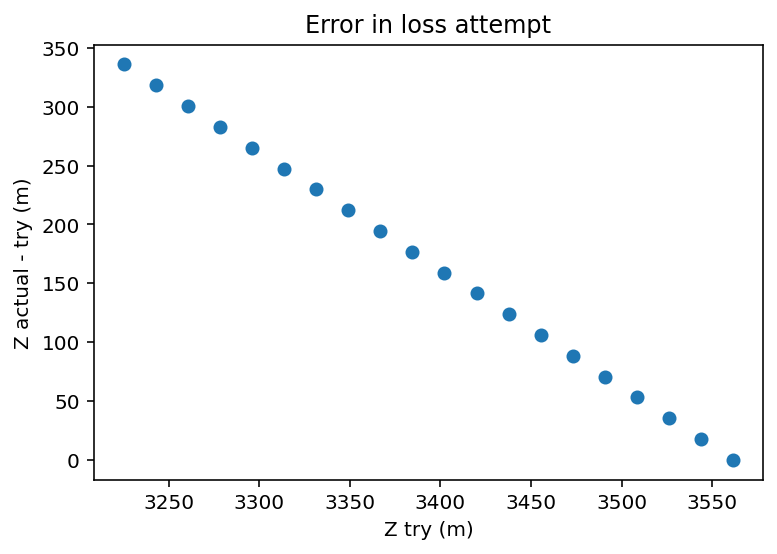

In [17]:
plt.title('Error in loss attempt')
plt.xlabel('Z try (m)')
plt.ylabel('Z actual - try (m)')
plt.scatter(Z_TRY, Z_ACTUAL- Z_TRY)